In [ ]:
# # # cheking the number of cored this system has.
# !cat /proc/cpuinfo | grep "cpu cores" | uniq

# # GPU info
# !nvidia-smi

# # Amount of system RAM available to be used.
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
# print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

# #finding the recursion limit to avoid Augmentation recursion error 
# import sys
# print(sys.getrecursionlimit())

# #installing fastai
# !pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#importing libraries and initializing fastai 
import pandas as pd 
import numpy as np 
import time

#Mounting google drive for saving the models after training 
from google.colab import drive
drive.mount('/content/drive')

from fastai.vision import *
from fastai.metrics import error_rate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loading the data 
#There are NaN values in the consumer_complaint_narrative column
train_raw = pd.read_csv('/content/drive/MyDrive/consumer_complaints.csv')
train_raw.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [ ]:
#Training data shape
train_raw.shape

(555957, 18)

In [ ]:
#Preprocessing the data 
#Extracting only those data whose consumer_complaint_narrative column is not null
#columns = 18
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(66806, 18)

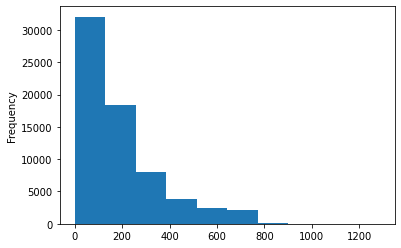

In [ ]:
#It splits the string into , separated values 
train_raw.consumer_complaint_narrative.apply(lambda x:len(x.split())).plot(kind='hist')

In [ ]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))

In [ ]:
train_raw.describe()

,complaint_id,len_txt
count,6.680600e+04,66806.000000
mean,1.571665e+06,190.644014
std,1.545692e+05,166.830597
min,1.290181e+06,1.000000
25%,1.443264e+06,71.000000
50%,1.569485e+06,136.000000
75%,1.702750e+06,254.000000
max,1.888608e+06,1284.000000


In [ ]:
train_raw.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id', 'len_txt'],
      dtype='object')

In [ ]:
train_raw.shape

(66806, 19)

In [ ]:
#Select only the rows with more than 250 words 
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(17142, 19)

In [ ]:
train_raw.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,len_txt
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524,666
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137,259
190251,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I spoke to XXXX of green tree representatives ...,NaN,Ditech Financial LLC,CA,948XX,NaN,Consent provided,Web,03/19/2015,Closed with non-monetary relief,Yes,No,1290534,301
190263,03/19/2015,Credit card,NaN,Other,NaN,i opened XXXX Bank of America credit cards 15-...,Company chooses not to provide a public response,Bank of America,OR,971XX,NaN,Consent provided,Web,03/19/2015,Closed with monetary relief,Yes,Yes,1292209,780
190264,03/19/2015,Consumer Loan,Vehicle loan,Taking out the loan or lease,NaN,I applied for a loan with XXXX XXXX and had pu...,NaN,Hyundai Capital America,MS,392XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1292159,558


In [ ]:
#selecting only the consumer_complaint_narrative and product columns
train_raw=train_raw[['consumer_complaint_narrative','product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card', 'Consumer Loan', 'Debt collection', 'Credit reporting', 'Student loan',
       'Bank account or service', 'Money transfers', 'Payday loan', 'Prepaid card', 'Other financial service'],
      dtype=object)

In [ ]:
#group similar products  dataframe.at = accessing a value using row column pair 
train_raw.at[train_raw['product']=='Credit reporting','product']= 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card or prepaid card', 'Consumer Loan', 'Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports', 'Student loan',
       'Bank account or service', 'Money transfers', 'Payday loan, title loan, or personal loan',
       'Other financial service'], dtype=object)

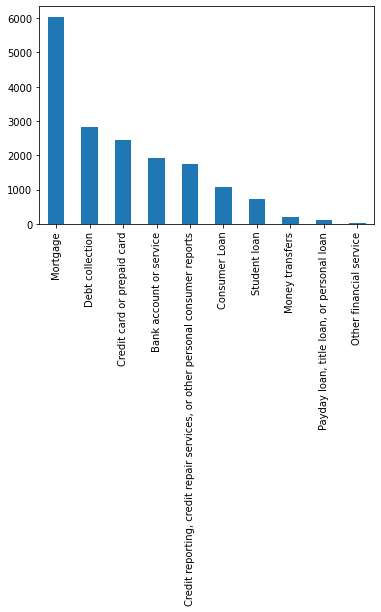

In [ ]:
train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')
#unbalanced dataset 

In [ ]:
#Renaming the columns 
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
#changing the categorical value column to integers

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [ ]:
len(np.unique(train_raw['label']))

10

In [ ]:
#creating the copy of the dataframe
#dataframe.copy(deep=True)  ==> This will create a copy and any changes to the copy will not be reflected in the original df
train = train_raw.copy()

In [ ]:
#reindexing to create randomness 
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
14869,I contacted Capitol One so that i could do a b...,2
7897,This complaint is being filed because I am con...,4
8953,On XXXX I reached out to Action Collection Age...,4
695,I attempted to settle this debt with this comp...,4
7920,I declared bankruptcy and had to make planned ...,4


In [ ]:
#remove the non-alphanumeric characters from the text 
import re 
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)     #() -- to match the sequence inside it , \-- to escape the special characters , 
                                     #\W -- get all the nonalphanumeric characters, + --all the instances 

  return text

In [ ]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
14869,I contacted Capitol One so that i could do a b...,2
7897,This complaint is being filed because I am con...,4
8953,On XXXX I reached out to Action Collection Age...,4
695,I attempted to settle this debt with this comp...,4
7920,I declared bankruptcy and had to make planned ...,4


In [ ]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,I contacted Capitol One so that i could do a b...,2
1,This complaint is being filed because I am con...,4


In [ ]:
train.shape

(17142, 2)

In [ ]:
#Installing the BERT module
!pip install bert-tensorflow
#!pip install bert-for-tf2

import bert
from bert import optimization

!pip install -q tf-models-official==2.4.0

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

     |████████████████████████████████| 64 kB 2.1 MB/s 
     |████████████████████████████████| 1.1 MB 8.1 MB/s 
     |████████████████████████████████| 47.6 MB 66 kB/s 
     |████████████████████████████████| 596 kB 51.7 MB/s 
     |████████████████████████████████| 1.1 MB 45.5 MB/s 
     |████████████████████████████████| 213 kB 66.2 MB/s 
     |████████████████████████████████| 352 kB 63.8 MB/s 
     |████████████████████████████████| 1.2 MB 36.7 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 99 kB 9.7 MB/s 



# Setting The Output Directory for BERT



In [ ]:
#Setting the output directory for BERT 
# Set the output directory for saving model file
#OUTPUT_DIR = '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific'
OUTPUT_DIR = '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.DeleteRecursively(OUTPUT_DIR)#deletes everything under the directory recursively
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR) #Creates a directory and all parent/intermediate directories.
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC *****


In [ ]:
print("Training Set Shape :", train.shape)
#print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (17142, 2)


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Splitting the Data into smaller chunks

In [ ]:
#Splitting the data into smaller chunks 
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200] #overlapping 50 words in every chunks 
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
def get_split_count(text1):
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  return n

In [ ]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,I contacted Capitol One so that i could do a b...,2,[I contacted Capitol One so that i could do a ...
1,This complaint is being filed because I am con...,4,[This complaint is being filed because I am co...
2,On XXXX I reached out to Action Collection Age...,4,[On XXXX I reached out to Action Collection Ag...
3,I attempted to settle this debt with this comp...,4,[I attempted to settle this debt with this com...
4,I declared bankruptcy and had to make planned ...,4,[I declared bankruptcy and had to make planned...


In [ ]:
train['text_split_count'] = train[DATA_COLUMN].apply(get_split_count)
train.head()

,text,label,text_split,text_split_count
0,I contacted Capitol One so that i could do a b...,2,[I contacted Capitol One so that i could do a ...,1
1,This complaint is being filed because I am con...,4,[This complaint is being filed because I am co...,3
2,On XXXX I reached out to Action Collection Age...,4,[On XXXX I reached out to Action Collection Ag...,1
3,I attempted to settle this debt with this comp...,4,[I attempted to settle this debt with this com...,2
4,I declared bankruptcy and had to make planned ...,4,[I declared bankruptcy and had to make planned...,1


In [ ]:
train.shape

(17142, 4)

In [ ]:
count_1 =0
count_2 =0
count_3 =0
count_4 =0
count_5 =0
for i in train['text_split_count']:
  if i==5:
    count_5+=1
  if i==1:
    count_1+=1
  if i==2:
    count_2+=1
  if i==3:
    count_3+=1
  if i==4:
    count_4+=1

In [ ]:
print('count_1 ', count_1)
print('count_2 ', count_2)
print('count_3 ', count_3)
print('count_4 ', count_4)
print('count_5 ', count_5)

count_1  4045
count_2  6873
count_3  3264
count_4  2758
count_5  202


In [ ]:
#creating the test set
test_set = train[(train['text_split_count'] == 4)]

In [ ]:
test_set

,text,label,text_split,text_split_count
11,On or about XX XX XXXX I received a letter off...,4,[On or about XX XX XXXX I received a letter of...,4
13,I traded my car on XX XX 2015 that was finance...,1,[I traded my car on XX XX 2015 that was financ...,4
20,I recently opened an XXXX XXXX XXXX Platinum S...,2,[I recently opened an XXXX XXXX XXXX Platinum ...,4
25,Please accept this as a formal complaint again...,6,[Please accept this as a formal complaint agai...,4
29,Purchased Items and Credit Holds like for a re...,2,[Purchased Items and Credit Holds like for a r...,4
...,...,...,...,...
17126,Starting in XXXX I started receiving calls fro...,1,[Starting in XXXX I started receiving calls fr...,4
17133,I went to XXXX XXXX College I graduated XXXX X...,9,[I went to XXXX XXXX College I graduated XXXX ...,4
17137,To whom it may concern During mortgage refinan...,6,[To whom it may concern During mortgage refina...,4
17138,Ocwen placed my condo up for a foreclosure auc...,6,[Ocwen placed my condo up for a foreclosure au...,4


In [ ]:
train.shape , test_set.shape

((17142, 4), (2758, 4))

In [ ]:
train = train[(train['text_split_count'].isin([1,2,3,5]))]

In [ ]:
train.shape

(14384, 4)

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label,text_split,text_split_count
16871,This complaint is regarding a debt of which I ...,4,[This complaint is regarding a debt of which I...,2
12483,Numerous issues but what is very concerning is...,6,[Numerous issues but what is very concerning i...,2
15240,I am working with XXXX XXXX I was told to pay ...,6,[I am working with XXXX XXXX I was told to pay...,2
2388,On XXXX XXXX I called my car company to ask if...,1,[On XXXX XXXX I called my car company to ask i...,5
7818,I opened a small business checking account wit...,0,[I opened a small business checking account wi...,3


In [ ]:
train.shape, val.shape, test_set.shape

((11507, 4), (2877, 4), (2758, 4))

In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:  #it is going to create list of training chunks with label and index mapping 
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(22818, 22818, 22818)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(5775, 5775, 5775)

In [ ]:
test_l = []
test_label_l = []
test_index_l = []
for idx,row in test_set.iterrows():
  for l in row['text_split']:
    test_l.append(l)
    test_label_l.append(row['label'])
    test_index_l.append(idx)
len(test_l), len(test_label_l), len(test_index_l)

(11032, 11032, 11032)

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,This complaint is regarding a debt of which I ...,4
1,when the total balance of 1800 00 was paid off...,4
2,Numerous issues but what is very concerning is...,6
3,before transferring to Seterus the loan modifi...,6
4,I am working with XXXX XXXX I was told to pay ...,6


In [ ]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,I called Capital One on XXXX XXXX 2015 about a...,2
1,Capital One on XXXX XXXX 2015 requesting resol...,2
2,I am filing this complaint with the CFPB out o...,6
3,in XXXX was in a XXXX and because of her finan...,6
4,HERE IS THE FIRST EMAIL I SENTGood Morning XX ...,0


In [ ]:
test_df = pd.DataFrame({DATA_COLUMN:test_l, LABEL_COLUMN:test_label_l})
test_df.head()

,text,label
0,On or about XX XX XXXX I received a letter off...,4
1,they never closed one of the personal accounts...,4
2,to them that the account on record is nt good ...,4
3,fee to close the account When I add all those ...,4
4,I traded my car on XX XX 2015 that was finance...,1


In [ ]:
print('train_df shape : ',train_df.shape)
print('val_df shape : ',val_df.shape)
print('test_df shape : ',test_df.shape)

train_df shape :  (22818, 2)
val_df shape :  (5775, 2)
test_df shape :  (11032, 2)


# BERT: Data Preprocessing

In [ ]:
class PaddingInputExample(object):
      pass

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
train_InputExamples_1 = train_df.apply(lambda x: InputExample(guid=None,
                                                                  text_a = x[DATA_COLUMN], 
                                                                  text_b = None, 
                                                                  label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples_1

0        <__main__.InputExample object at 0x7fc394845250>
1        <__main__.InputExample object at 0x7fc3dd961590>
2        <__main__.InputExample object at 0x7fc3dd961710>
3        <__main__.InputExample object at 0x7fc394d87350>
4        <__main__.InputExample object at 0x7fc394d87e10>
                               ...                       
22813    <__main__.InputExample object at 0x7fc394347490>
22814    <__main__.InputExample object at 0x7fc3943474d0>
22815    <__main__.InputExample object at 0x7fc394347510>
22816    <__main__.InputExample object at 0x7fc394347550>
22817    <__main__.InputExample object at 0x7fc394347590>
Length: 22818, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples_1.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples_1.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples_1.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples_1.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  This complaint is regarding a debt of which I XXXX XXXX advised the company PRA Portfolio Recovery Associates LLC that I would pay a settlement or a portion of the amount owed by my son XXXX XXXX My son XXXX XXXX gave PRA permissin to speak with me regarding his account Arrangements were made on XXXX XXXX 2015 after receiving notification from local law offices that a judgement had been filed against my son however we never received notification via mail of the judgement from PRA In order to to settle the debt which the original amount owed was 2600 00 however the settlement I agreed upon was made for total of 1800 00 a difference of 800 00 taken off the original balance The agreement made included giving PRA permission to debit my checking account beginning XXXX XXXX 2015 in bi weekly in the amount of XXXX to conclude when the total balance of 1800 00 was paid off I requested documentation of the settle

In [ ]:
val_InputExamples_1 = val_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
test_InputExamples_1 = test_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

# BERT: Loading the pre-trained model

In [ ]:
import official.nlp.bert.tokenization as tokenization

In [ ]:
# ##We are creatung the tokens to gorm the vocabulary which inturn is ued to represent the words
# #BERT: Loading the pre-trained model
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.compat.v1.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
#Defining Input features 
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example

In [ ]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

In [ ]:
def convert_examples_to_features(tokenizer, examples, max_seq_length=200):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels,features = [], [], [], [],[]
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )

        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

        feature = InputFeatures(input_ids=input_id,
        input_mask=input_mask,
        segment_ids=segment_id,
        label_id=label,
        is_real_example=True)

        features.append(feature)
    # return(
    #     np.array(input_ids),
    #     np.array(input_masks),
    #     np.array(segment_ids),
    #     np.array(labels).reshape(-1, 1),
    # )
    return features

In [ ]:
import tqdm
MAX_SEQ_LENGTH = 200

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.

train_features = convert_examples_to_features(tokenizer, train_InputExamples_1, MAX_SEQ_LENGTH)

val_features = convert_examples_to_features(tokenizer, val_InputExamples_1, MAX_SEQ_LENGTH)

test_features = convert_examples_to_features(tokenizer, test_InputExamples_1, MAX_SEQ_LENGTH)

Converting examples to features: 100%|██████████| 11032/11032 [00:41<00:00, 263.72it/s]


In [ ]:
print("Sentence : ", train_InputExamples_1.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  This complaint is regarding a debt of which I XXXX XXXX advised the company PRA Portfolio Recovery Associates LLC that I would pay a settlement or a portion of the amount owed by my son XXXX XXXX My son XXXX XXXX gave PRA permissin to speak with me regarding his account Arrangements were made on XXXX XXXX 2015 after receiving notification from local law offices that a judgement had been filed against my son however we never received notification via mail of the judgement from PRA In order to to settle the debt which the original amount owed was 2600 00 however the settlement I agreed upon was made for total of 1800 00 a difference of 800 00 taken off the original balance The agreement made included giving PRA permission to debit my checking account beginning XXXX XXXX 2015 in bi weekly in the amount of XXXX to conclude when the total balance of 1800 00 was paid off I requested documentation of the settlement agreement with the current settlement balance owed on several occa

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1]

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# # Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)

(1426, 10)

In [ ]:
#Initializing the model and the estimator   <USE THIS BLOCK IF YOU ARE TRAINING FOR THE FIRST TIME>
# model_fn = model_fn_builder(
#   num_labels=len(label_list),
#   learning_rate=LEARNING_RATE,
#   num_train_steps=num_train_steps,
#   num_warmup_steps=num_warmup_steps)

# estimator = tf.estimator.Estimator(
#   model_fn=model_fn,
#   config=run_config,
#   params={"batch_size": BATCH_SIZE})

In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
import datetime

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#Run this If you want to load the model 
#Loading a specific check point : df_train , df_val (yes) -->all counts 
warm_start = tf.estimator.WarmStartSettings(ckpt_to_initialize_from='/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929.meta')


model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator=tf.estimator.Estimator(model_fn=model_fn,
                       config=run_config,
                       params={"batch_size": BATCH_SIZE},
                       warm_start_from=warm_start)

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
#Evaluation of the BERT model
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-10-22T20:02:11


INFO:tensorflow:Starting evaluation at 2021-10-22T20:02:11


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 63.06046s


INFO:tensorflow:Inference Time : 63.06046s


INFO:tensorflow:Finished evaluation at 2021-10-22-20:03:14


INFO:tensorflow:Finished evaluation at 2021-10-22-20:03:14


INFO:tensorflow:Saving dict for global step 1929: eval_accuracy = 0.87948054, false_negatives = 90.0, false_positives = 98.0, global_step = 1929, loss = 0.42118967, true_negatives = 527.0, true_positives = 5060.0


INFO:tensorflow:Saving dict for global step 1929: eval_accuracy = 0.87948054, false_negatives = 90.0, false_positives = 98.0, global_step = 1929, loss = 0.42118967, true_negatives = 527.0, true_positives = 5060.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1929: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1929: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


{'eval_accuracy': 0.87948054,
 'false_negatives': 90.0,
 'false_positives': 98.0,
 'global_step': 1929,
 'loss': 0.42118967,
 'true_negatives': 527.0,
 'true_positives': 5060.0}

# Extract Embeddings from BERT

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    number = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='number')
    receiver_tensors = {'number': number}
    features = tf.tile(number, multiples=[1, 2])
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  #input_features = convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  input_features = convert_examples_to_features(tokenizer,input_examples,MAX_SEQ_LENGTH )
  #Predicting the classes 
  predict_input_fn = input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
MAX_SEQ_LENGTH

200

In [ ]:
train_df.shape, val_df.shape , test_df.shape

((22818, 2), (5775, 2), (11032, 2))

In [ ]:
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 22818/22818 [01:22<00:00, 275.15it/s]


In [ ]:
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 5775/5775 [00:20<00:00, 281.84it/s]


In [ ]:
test_emb = np.apply_along_axis(getPrediction, 0,np.array(test_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 11032/11032 [00:39<00:00, 277.59it/s]


In [ ]:
 tr_emb.shape,val_emb.shape,test_emb.shape

((22818, 768), (5775, 768), (11032, 768))

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())

train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[0.20092003, -0.07730835, -0.21618436, 0.1712...",4
1,"[[0.8105164, -0.7295193, -0.51318717, -0.53265...",6
2,"[[0.830818, -0.7751458, -0.77382296, -0.478961...",6
3,"[[-0.45432633, -0.17963387, -0.97538894, 0.913...",1
4,"[[-0.8059017, -0.66528237, -0.56747127, 0.6983...",0


In [ ]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[-0.77161187, -0.77001286, -0.99243504, 0.970...",2
1,"[[0.81443745, -0.73579687, -0.50367063, -0.551...",6
2,"[[-0.3156167, -0.93835175, -0.9996575, 0.85169...",0
3,"[[-0.7355605, -0.71444535, -0.89994687, 0.9236...",2
4,"[[-0.12521741, 0.29357836, -0.5068497, 0.31966...",4


In [ ]:
aux = -1
len_l = 0
test_x = {}

for l, emb in zip(test_index_l, test_emb):
  if l in test_x.keys():
    test_x[l]  =np.vstack([test_x[l], emb])
  else:
    test_x[l] = [emb]


test_l_final = []
telabel_l_final = []
for k in test_x.keys():
  test_l_final.append(test_x[k])
  telabel_l_final.append(test_set.loc[k]['label'])

df_test = pd.DataFrame({'emb': test_l_final, 'label': telabel_l_final})
df_test.head()

,emb,label
0,"[[0.2621254, -0.16344805, -0.32026872, 0.25745...",4
1,"[[-0.8374758, -0.19735436, -0.89110494, 0.9482...",1
2,"[[-0.7624747, -0.7134729, -0.9453613, 0.940214...",2
3,"[[0.85646725, -0.7222282, -0.5811699, -0.52379...",6
4,"[[-0.7607529, -0.8333792, -0.95208997, 0.90225...",2


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((11507, 2), (2877, 2), (2758, 2))

In [ ]:
def finding_mean(mat):
    return np.mean(mat, axis=0)

# Picking chunks Only with High variance

In [ ]:
#Stacking
train_var=[]
for data in range(df_train['emb'].shape[0]):
  temp={}
  if len(df_train['emb'][data]) !=1:
    covMatrix = np.cov(df_train['emb'][data],bias=True)
    eigen_vals , eigen_vectors = np.linalg.eig(covMatrix)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigen_vals[i]), eigen_vectors[:,i]) for i in range(len(eigen_vals))]

    tot = sum(eigen_vals)
    var_exp = [(i / tot)*100 for i in eigen_vals]
    cum_var_exp = np.cumsum(var_exp)

    for i in range(len(var_exp)):
      if var_exp[i] > 5:
         emb_l= df_train['emb'][data][i]
         if data in temp.keys():
            temp[data]  =np.vstack([temp[data],emb_l])  
         else:
            temp[data] = [emb_l]
  else:
    temp[data] =df_train['emb'][data]
  train_var.append(temp[data])

In [ ]:
df_train_var = pd.DataFrame({'emb': train_var, 'label': df_train['label']})
df_train_var.head()
df_train_var['mean_emb'] = df_train_var['emb'].apply(finding_mean)

In [ ]:
df_train.head(2)

,emb,label
0,"[[0.20092003, -0.07730835, -0.21618436, 0.1712...",4
1,"[[0.8105164, -0.7295193, -0.51318717, -0.53265...",6


In [ ]:
df_train_var.head(2)

,emb,label,mean_emb
0,"[[-0.029488936, -0.33118686, -0.8926615, 0.709...",4,"[-0.029488936, -0.33118686, -0.8926615, 0.7098..."
1,"[[0.8105164, -0.7295193, -0.51318717, -0.53265...",6,"[0.8105164, -0.7295193, -0.51318717, -0.532654..."


In [ ]:
df_val.reset_index(drop=True, inplace=True)
df_val.head(2)

,emb,label
0,"[[-0.77161187, -0.77001286, -0.99243504, 0.970...",2
1,"[[0.81443745, -0.73579687, -0.50367063, -0.551...",6


In [ ]:
##creating the validation set 
val_var=[]
for data in range(df_val['emb'].shape[0]):
  temp={}
  if len(df_val['emb'][data]) !=1:
    covMatrix = np.cov(df_val['emb'][data],bias=True)
    eigen_vals , eigen_vectors = np.linalg.eig(covMatrix)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigen_vals[i]), eigen_vectors[:,i]) for i in range(len(eigen_vals))]

    tot = sum(eigen_vals)
    var_exp = [(i / tot)*100 for i in eigen_vals]
    cum_var_exp = np.cumsum(var_exp)

    for i in range(len(var_exp)):
      if var_exp[i] > 5:
         emb_l= df_val['emb'][data][i]
         if data in temp.keys():
            temp[data]  =np.vstack([temp[data],emb_l])  
         else:
            temp[data] = [emb_l]
  else:
    temp[data] =df_val['emb'][data]
  val_var.append(temp[data])

df_val_var = pd.DataFrame({'emb': val_var, 'label': df_val['label']})
df_val_var.head()
df_val_var['mean_emb'] = df_val_var['emb'].apply(finding_mean)

In [ ]:
df_test.reset_index(drop=True, inplace=True)
df_test.head(2)

,emb,label
0,"[[0.2621254, -0.16344805, -0.32026872, 0.25745...",4
1,"[[-0.8374758, -0.19735436, -0.89110494, 0.9482...",1


In [ ]:
##creating the test data 
test_var=[]
for data in range(df_test['emb'].shape[0]):
  temp={}
  if len(df_test['emb'][data]) !=1:
    covMatrix = np.cov(df_test['emb'][data],bias=True)
    eigen_vals , eigen_vectors = np.linalg.eig(covMatrix)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigen_vals[i]), eigen_vectors[:,i]) for i in range(len(eigen_vals))]

    tot = sum(eigen_vals)
    var_exp = [(i / tot)*100 for i in eigen_vals]
    cum_var_exp = np.cumsum(var_exp)

    for i in range(len(var_exp)):
      if var_exp[i] > 5:
         emb_l= df_test['emb'][data][i]
         if data in temp.keys():
            temp[data]  =np.vstack([temp[data],emb_l])  
         else:
            temp[data] = [emb_l]
  else:
    temp[data] =df_test['emb'][data]
  test_var.append(temp[data])

df_test_var = pd.DataFrame({'emb': test_var, 'label': df_test['label']})
df_test_var.head()
df_test_var['mean_emb'] = df_test_var['emb'].apply(finding_mean)

In [ ]:
df_train_var.shape , df_val_var.shape, df_test_var.shape

((11507, 3), (2877, 3), (2758, 3))

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((11507, 2), (2877, 2), (2758, 2))

In [ ]:
type(df_train_var['emb'][2])

list

In [ ]:
type(df_train['emb'][2])

numpy.ndarray

In [ ]:
def get_split_count_1(text):
  return len(text)

In [ ]:
df_train_var['text_split_count'] = df_train_var['emb'].apply(get_split_count_1)
df_train_var.head()

,emb,label,mean_emb,text_split_count
0,"[[-0.029488936, -0.33118686, -0.8926615, 0.709...",4,"[-0.029488936, -0.33118686, -0.8926615, 0.7098...",1
1,"[[0.8105164, -0.7295193, -0.51318717, -0.53265...",6,"[0.8105164, -0.7295193, -0.51318717, -0.532654...",1
2,"[[0.83860356, -0.7500832, -0.535902, -0.642707...",6,"[0.83860356, -0.7500832, -0.535902, -0.6427073...",1
3,"[[-0.45432633, -0.17963387, -0.97538894, 0.913...",1,"[-0.45432633, -0.17963387, -0.97538894, 0.9136...",1
4,"[[-0.8059017, -0.66528237, -0.56747127, 0.6983...",0,"[-0.5695304, -0.7304577, -0.8508846, 0.7767968...",3


In [ ]:
df_train['text_split_count'] = df_train['emb'].apply(get_split_count_1)
df_train.head()

,emb,label,text_split_count
0,"[[0.20092003, -0.07730835, -0.21618436, 0.1712...",4,2
1,"[[0.8105164, -0.7295193, -0.51318717, -0.53265...",6,2
2,"[[0.830818, -0.7751458, -0.77382296, -0.478961...",6,2
3,"[[-0.45432633, -0.17963387, -0.97538894, 0.913...",1,5
4,"[[-0.8059017, -0.66528237, -0.56747127, 0.6983...",0,3


In [ ]:
df_test['text_split_count'] = df_test['emb'].apply(get_split_count_1)
df_test_var['text_split_count'] = df_test_var['emb'].apply(get_split_count_1)

In [ ]:
max(df_test_var['text_split_count'].unique())

4

In [ ]:
max(df_test['text_split_count'].unique())

4

In [ ]:
max(df_train_var['text_split_count'].unique())

3

# LSTM Model Creation

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 768)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               347600    
_________________________________________________________________
dense (Dense)                (None, 30)                3030      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 350,940
Trainable params: 350,940
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_sequences = len(df_train_var['mean_emb'].to_list())
batch_size = 37
batches_per_epoch =  311
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['mean_emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['mean_emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val_var['mean_emb'].to_list())
batch_size_val = 3
batches_per_epoch_val = 959
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['mean_emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['mean_emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
model.fit_generator(train_generator(df_train_var), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val_var), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/10
311/311 [==============================] - ETA: 0s - batch: 155.0000 - size: 37.0000 - loss: 0.3808 - acc: 0.9011

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


311/311 [==============================] - 492s 2s/step - batch: 155.0000 - size: 37.0000 - loss: 0.3808 - acc: 0.9011 - val_loss: 0.3591 - val_acc: 0.9013 - lr: 0.0010
Epoch 2/10
311/311 [==============================] - 486s 2s/step - batch: 155.0000 - size: 37.0000 - loss: 0.3231 - acc: 0.9116 - val_loss: 0.3668 - val_acc: 0.9016 - lr: 0.0010
Epoch 3/10
311/311 [==============================] - 483s 2s/step - batch: 155.0000 - size: 37.0000 - loss: 0.3107 - acc: 0.9136 - val_loss: 0.3530 - val_acc: 0.9058 - lr: 0.0010
Epoch 4/10
311/311 [==============================] - ETA: 0s - batch: 155.0000 - size: 37.0000 - loss: 0.3031 - acc: 0.9156
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
311/311 [==============================] - 482s 2s/step - batch: 155.0000 - size: 37.0000 - loss: 0.3031 - acc: 0.9156 - val_loss: 0.3588 - val_acc: 0.9023 - lr: 0.0010
Epoch 5/10
311/311 [==============================] - 482s 2s/step - batch: 155.0000 - size: 37.0

In [ ]:
num_sequences_val = len(df_test_var['mean_emb'].to_list())
batch_size_val = 2
batches_per_epoch_val = 1379
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test_var), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.2653565752177153, 0.9249456]

In [ ]:
y_proba=model.predict(val_generator(df_test_var), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_var['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_var['label']))

Confusion Matrix
[[ 286    2   10    4 ...    4    1    0    0]
 [   3  136    3    4 ...    2    0    0    0]
 [  21    3  331    2 ...    2    2    0    0]
 [   0    1    2  158 ...    2    0    0    2]
 ...
 [  12    3    1    1 ... 1248    0    0    1]
 [   0    0    0    0 ...    0    0    0    0]
 [   0    1    0    0 ...    0    0    2    0]
 [   1    1    0    0 ...    1    1    0  108]]
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       327
           1       0.91      0.87      0.89       156
           2       0.93      0.90      0.91       368
           3       0.87      0.94      0.90       168
           4       0.85      0.84      0.84       312
           5       0.57      0.91      0.70        22
           6       0.98      0.97      0.98      1285
           7       0.00      0.00      0.00         0
           8       0.50      0.50      0.50         4
           9       0.92      0.93     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

diag = np.diagonal(mat)
sum(diag)

2551

2551

# Stack chunks with High Variance

In [ ]:
model.fit_generator(train_generator(df_train_var), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val_var), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/10
310/311 [============================>.] - ETA: 0s - batch: 154.5000 - size: 37.0000 - loss: 0.4092 - acc: 0.9015

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


311/311 [==============================] - 4s 12ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.4089 - acc: 0.9015 - val_loss: 0.3458 - val_acc: 0.9068 - lr: 0.0010
Epoch 2/10
311/311 [==============================] - 3s 11ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.3141 - acc: 0.9148 - val_loss: 0.3316 - val_acc: 0.9072 - lr: 0.0010
Epoch 3/10
311/311 [==============================] - 4s 11ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.2993 - acc: 0.9162 - val_loss: 0.3247 - val_acc: 0.9065 - lr: 0.0010
Epoch 4/10
309/311 [============================>.] - ETA: 0s - batch: 154.0000 - size: 37.0000 - loss: 0.2892 - acc: 0.9194
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
311/311 [==============================] - 4s 11ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.2892 - acc: 0.9194 - val_loss: 0.3261 - val_acc: 0.9048 - lr: 0.0010
Epoch 5/10
311/311 [==============================] - 4s 11ms/step - batch: 155.0000 - size: 37.0

In [ ]:
num_sequences_val = len(df_test_var['emb'].to_list())
batch_size_val = 2
batches_per_epoch_val = 1379
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test_var), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.253798247058363, 0.9260334]

In [ ]:
y_proba=model.predict(val_generator(df_test_var), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_var['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_var['label']))

Confusion Matrix
[[ 296    3   20    3 ...    3    1    0    0]
 [   2  135    4    2 ...    2    0    0    0]
 [  11    4  317    2 ...    1    2    0    0]
 [   2    1    4  161 ...    2    0    0    3]
 ...
 [  11    3    1    1 ... 1254    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]
 [   0    1    0    0 ...    0    0    3    0]
 [   0    0    0    0 ...    1    1    0  110]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       342
           1       0.90      0.89      0.90       151
           2       0.89      0.92      0.90       344
           3       0.88      0.88      0.88       182
           4       0.83      0.87      0.85       295
           5       0.63      0.73      0.68        30
           6       0.99      0.97      0.98      1294
           7       0.00      0.00      0.00         0
           8       0.75      0.75      0.75         4
           9       0.94      0.95     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

diag = np.diagonal(mat)
sum(diag)

2554

# Results of Embeddings from BERT finetuned on only 1,2,3 and 5 chunks

In [ ]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


305/311 [============================>.] - ETA: 0s - batch: 152.0000 - size: 37.0000 - loss: 0.3796 - acc: 0.9108

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


311/311 [==============================] - 7s 19ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.3790 - acc: 0.9103 - val_loss: 0.4269 - val_acc: 0.8832 - lr: 0.0010
Epoch 2/10
311/311 [==============================] - 6s 20ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.2901 - acc: 0.9197 - val_loss: 0.4180 - val_acc: 0.8867 - lr: 0.0010
Epoch 3/10
311/311 [==============================] - 6s 19ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.2754 - acc: 0.9221 - val_loss: 0.4171 - val_acc: 0.8846 - lr: 0.0010
Epoch 4/10
308/311 [============================>.] - ETA: 0s - batch: 153.5000 - size: 37.0000 - loss: 0.2652 - acc: 0.9246
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
311/311 [==============================] - 6s 19ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.2645 - acc: 0.9247 - val_loss: 0.4130 - val_acc: 0.8884 - lr: 0.0010
Epoch 5/10
311/311 [==============================] - 6s 20ms/step - batch: 155.0000 - size: 37.0

In [ ]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 2
batches_per_epoch_val = 1379
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.38509348009355393, 0.8973894]

In [ ]:
x_test = np.array(df_test['emb']).reshape(-1,1)

In [ ]:
y_proba=model.predict(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[ 262    3    9    2 ...    6    1    0    0]
 [   1  119    2    4 ...    4    0    1    1]
 [  40    7  325    5 ...    2    2    0    0]
 [   2    2    3  153 ...    2    0    0    4]
 ...
 [  12    6    1    1 ... 1244    0    0    1]
 [   0    0    0    0 ...    0    0    0    0]
 [   0    2    0    0 ...    0    0    1    0]
 [   2    1    1    0 ...    2    1    0   98]]
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       295
           1       0.79      0.86      0.82       139
           2       0.91      0.82      0.86       397
           3       0.84      0.91      0.87       168
           4       0.81      0.78      0.80       321
           5       0.63      0.69      0.66        32
           6       0.98      0.96      0.97      1295
           7       0.00      0.00      0.00         0
           8       0.25      0.25      0.25         4
           9       0.84      0.92     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

diag = np.diagonal(mat)
sum(diag)

2475

# Results of Embeddings from BERT finetuned on all the chunks

In [ ]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/10
311/311 [==============================] - ETA: 0s - batch: 155.0000 - size: 37.0000 - loss: 0.3848 - acc: 0.9068

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


311/311 [==============================] - 7s 20ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.3848 - acc: 0.9068 - val_loss: 0.3338 - val_acc: 0.9055 - lr: 0.0010
Epoch 2/10
311/311 [==============================] - 6s 20ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.3051 - acc: 0.9147 - val_loss: 0.3204 - val_acc: 0.9121 - lr: 0.0010
Epoch 3/10
311/311 [==============================] - 6s 20ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.2876 - acc: 0.9189 - val_loss: 0.3172 - val_acc: 0.9086 - lr: 0.0010
Epoch 4/10
306/311 [============================>.] - ETA: 0s - batch: 152.5000 - size: 37.0000 - loss: 0.2772 - acc: 0.9192
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
311/311 [==============================] - 6s 20ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.2769 - acc: 0.9194 - val_loss: 0.3154 - val_acc: 0.9093 - lr: 0.0010
Epoch 5/10
311/311 [==============================] - 6s 20ms/step - batch: 155.0000 - size: 37.0

In [ ]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 2
batches_per_epoch_val = 1379
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.24704876316520855, 0.9296592]

In [ ]:
df_test

,emb,label
0,"[[-0.09913615, -0.17079206, -0.86548907, -0.32...",6
1,"[[-0.40635964, -0.45109355, 0.8118932, 0.54926...",3
2,"[[-0.94710577, 0.0961494, 0.6864101, 0.9585997...",2
3,"[[-0.03629237, -0.09790429, -0.7638479, -0.401...",6
4,"[[-0.43871877, -0.18963364, -0.2035, 0.5046583...",5
...,...,...
2753,"[[-0.9460584, 0.04502233, 0.7314346, 0.9536967...",2
2754,"[[0.10824093, -0.511583, -0.16921353, -0.09237...",4
2755,"[[-0.4812319, -0.03634998, -0.041603733, 0.738...",5
2756,"[[-0.17148226, -0.28607288, -0.64220124, 0.347...",9


In [ ]:
x_test = np.array(df_test['emb']).reshape(-1,1)

In [ ]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 2
batches_per_epoch_val = 1379
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
y_proba=model.predict(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_proba

array([[2.370830e-04, 4.691653e-04, 2.616480e-06, 9.697804e-05, ..., 9.973685e-01, 1.763009e-05, 8.314756e-07,
        4.500242e-06],
       [1.744184e-04, 2.326799e-05, 1.397982e-04, 9.933581e-01, ..., 1.364442e-04, 1.137589e-05, 2.211602e-05,
        3.585977e-04],
       [1.490154e-02, 1.967586e-02, 8.071851e-01, 1.661687e-03, ..., 6.352366e-05, 6.531275e-04, 6.077666e-05,
        3.923567e-04],
       [3.458704e-04, 4.540892e-04, 3.876120e-06, 5.719704e-05, ..., 9.973620e-01, 1.564242e-05, 9.806255e-07,
        5.126925e-06],
       ...,
       [8.399286e-04, 4.699164e-02, 1.209545e-03, 4.507670e-01, ..., 4.813152e-02, 8.159522e-04, 8.763800e-04,
        4.077824e-03],
       [1.134196e-02, 3.092889e-03, 5.716724e-03, 6.208710e-05, ..., 8.194603e-04, 3.291529e-02, 4.633973e-05,
        3.092204e-03],
       [1.138884e-05, 1.699179e-04, 4.508135e-04, 5.776087e-03, ..., 1.443026e-05, 5.063273e-05, 1.434704e-05,
        3.412661e-03],
       [1.636653e-03, 1.923281e-03, 3.283809e-05, 

In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[ 291    0   16    2 ...   13    1    0    0]
 [   1  140    3    3 ...    0    0    3    0]
 [  18    1  320    4 ...    1    2    0    0]
 [   0    0    2  166 ...    1    0    0    1]
 ...
 [  11    4    1    1 ... 1247    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]
 [   0    1    0    0 ...    0    0    0    0]
 [   1    1    1    0 ...    2    1    0  108]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       333
           1       0.93      0.90      0.92       155
           2       0.90      0.90      0.90       356
           3       0.91      0.94      0.92       177
           4       0.85      0.87      0.86       303
           5       0.77      0.77      0.77        35
           6       0.98      0.97      0.98      1283
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.92      0.94     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Just for reference -->DO NOT RUN IT
# #BERT: Fine Tuning Training & Evaluating
# print(f'Beginning Training!')
# #current_time = datetime.time()
# estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
# #print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.269146, step = 0


INFO:tensorflow:loss = 2.269146, step = 0


INFO:tensorflow:global_step/sec: 2.03454


INFO:tensorflow:global_step/sec: 2.03454


INFO:tensorflow:loss = 1.0293264, step = 100 (49.153 sec)


INFO:tensorflow:loss = 1.0293264, step = 100 (49.153 sec)


INFO:tensorflow:global_step/sec: 2.47521


INFO:tensorflow:global_step/sec: 2.47521


INFO:tensorflow:loss = 1.0047464, step = 200 (40.401 sec)


INFO:tensorflow:loss = 1.0047464, step = 200 (40.401 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:global_step/sec: 2.14739


INFO:tensorflow:global_step/sec: 2.14739


INFO:tensorflow:loss = 0.8332013, step = 300 (46.568 sec)


INFO:tensorflow:loss = 0.8332013, step = 300 (46.568 sec)


INFO:tensorflow:global_step/sec: 2.47347


INFO:tensorflow:global_step/sec: 2.47347


INFO:tensorflow:loss = 1.0196545, step = 400 (40.429 sec)


INFO:tensorflow:loss = 1.0196545, step = 400 (40.429 sec)


INFO:tensorflow:global_step/sec: 2.47606


INFO:tensorflow:global_step/sec: 2.47606


INFO:tensorflow:loss = 0.5582099, step = 500 (40.387 sec)


INFO:tensorflow:loss = 0.5582099, step = 500 (40.387 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:global_step/sec: 2.16216


INFO:tensorflow:global_step/sec: 2.16216


INFO:tensorflow:loss = 0.70514524, step = 600 (46.250 sec)


INFO:tensorflow:loss = 0.70514524, step = 600 (46.250 sec)


INFO:tensorflow:global_step/sec: 2.47374


INFO:tensorflow:global_step/sec: 2.47374


INFO:tensorflow:loss = 1.2256243, step = 700 (40.425 sec)


INFO:tensorflow:loss = 1.2256243, step = 700 (40.425 sec)


INFO:tensorflow:global_step/sec: 2.47581


INFO:tensorflow:global_step/sec: 2.47581


INFO:tensorflow:loss = 0.23693301, step = 800 (40.391 sec)


INFO:tensorflow:loss = 0.23693301, step = 800 (40.391 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:global_step/sec: 2.13953


INFO:tensorflow:global_step/sec: 2.13953


INFO:tensorflow:loss = 1.0314894, step = 900 (46.739 sec)


INFO:tensorflow:loss = 1.0314894, step = 900 (46.739 sec)


INFO:tensorflow:global_step/sec: 2.47311


INFO:tensorflow:global_step/sec: 2.47311


INFO:tensorflow:loss = 0.50885725, step = 1000 (40.436 sec)


INFO:tensorflow:loss = 0.50885725, step = 1000 (40.436 sec)


INFO:tensorflow:global_step/sec: 2.47567


INFO:tensorflow:global_step/sec: 2.47567


INFO:tensorflow:loss = 0.3976738, step = 1100 (40.393 sec)


INFO:tensorflow:loss = 0.3976738, step = 1100 (40.393 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:global_step/sec: 2.14793


INFO:tensorflow:global_step/sec: 2.14793


INFO:tensorflow:loss = 0.48501277, step = 1200 (46.556 sec)


INFO:tensorflow:loss = 0.48501277, step = 1200 (46.556 sec)


INFO:tensorflow:global_step/sec: 2.47377


INFO:tensorflow:global_step/sec: 2.47377


INFO:tensorflow:loss = 0.2039797, step = 1300 (40.424 sec)


INFO:tensorflow:loss = 0.2039797, step = 1300 (40.424 sec)


INFO:tensorflow:global_step/sec: 2.47695


INFO:tensorflow:global_step/sec: 2.47695


INFO:tensorflow:loss = 0.35457504, step = 1400 (40.372 sec)


INFO:tensorflow:loss = 0.35457504, step = 1400 (40.372 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:global_step/sec: 2.08047


INFO:tensorflow:global_step/sec: 2.08047


INFO:tensorflow:loss = 0.5878937, step = 1500 (48.067 sec)


INFO:tensorflow:loss = 0.5878937, step = 1500 (48.067 sec)


INFO:tensorflow:global_step/sec: 2.47501


INFO:tensorflow:global_step/sec: 2.47501


INFO:tensorflow:loss = 0.3608415, step = 1600 (40.403 sec)


INFO:tensorflow:loss = 0.3608415, step = 1600 (40.403 sec)


INFO:tensorflow:global_step/sec: 2.47714


INFO:tensorflow:global_step/sec: 2.47714


INFO:tensorflow:loss = 0.36334234, step = 1700 (40.369 sec)


INFO:tensorflow:loss = 0.36334234, step = 1700 (40.369 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1800...


INFO:tensorflow:Saving checkpoints for 1800 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1800 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1800...


INFO:tensorflow:global_step/sec: 2.15762


INFO:tensorflow:global_step/sec: 2.15762


INFO:tensorflow:loss = 0.2758512, step = 1800 (46.347 sec)


INFO:tensorflow:loss = 0.2758512, step = 1800 (46.347 sec)


INFO:tensorflow:global_step/sec: 2.47499


INFO:tensorflow:global_step/sec: 2.47499


INFO:tensorflow:loss = 0.64759105, step = 1900 (40.404 sec)


INFO:tensorflow:loss = 0.64759105, step = 1900 (40.404 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1982...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1982...


INFO:tensorflow:Saving checkpoints for 1982 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1982 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1982...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1982...


INFO:tensorflow:Loss for final step: 0.43535817.


INFO:tensorflow:Loss for final step: 0.43535817.


In [ ]:
#@title Default title text--> Training for Specific chunks 1235
# #BERT: Fine Tuning Training & Evaluating
# print(f'Beginning Training!')
#current_time = datetime.time()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
#print("Training took time ", datetime.now() - current_time)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.4899771, step = 0


INFO:tensorflow:loss = 2.4899771, step = 0


INFO:tensorflow:global_step/sec: 1.98394


INFO:tensorflow:global_step/sec: 1.98394


INFO:tensorflow:loss = 1.1292038, step = 100 (50.408 sec)


INFO:tensorflow:loss = 1.1292038, step = 100 (50.408 sec)


INFO:tensorflow:global_step/sec: 2.47048


INFO:tensorflow:global_step/sec: 2.47048


INFO:tensorflow:loss = 1.1794319, step = 200 (40.479 sec)


INFO:tensorflow:loss = 1.1794319, step = 200 (40.479 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:global_step/sec: 2.08758


INFO:tensorflow:global_step/sec: 2.08758


INFO:tensorflow:loss = 1.1732023, step = 300 (47.900 sec)


INFO:tensorflow:loss = 1.1732023, step = 300 (47.900 sec)


INFO:tensorflow:global_step/sec: 2.46796


INFO:tensorflow:global_step/sec: 2.46796


INFO:tensorflow:loss = 0.40280747, step = 400 (40.519 sec)


INFO:tensorflow:loss = 0.40280747, step = 400 (40.519 sec)


INFO:tensorflow:global_step/sec: 2.47328


INFO:tensorflow:global_step/sec: 2.47328


INFO:tensorflow:loss = 0.88792235, step = 500 (40.432 sec)


INFO:tensorflow:loss = 0.88792235, step = 500 (40.432 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:global_step/sec: 2.0888


INFO:tensorflow:global_step/sec: 2.0888


INFO:tensorflow:loss = 0.5372505, step = 600 (47.874 sec)


INFO:tensorflow:loss = 0.5372505, step = 600 (47.874 sec)


INFO:tensorflow:global_step/sec: 2.47054


INFO:tensorflow:global_step/sec: 2.47054


INFO:tensorflow:loss = 0.94983196, step = 700 (40.479 sec)


INFO:tensorflow:loss = 0.94983196, step = 700 (40.479 sec)


INFO:tensorflow:global_step/sec: 2.47367


INFO:tensorflow:global_step/sec: 2.47367


INFO:tensorflow:loss = 0.9150766, step = 800 (40.424 sec)


INFO:tensorflow:loss = 0.9150766, step = 800 (40.424 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:global_step/sec: 2.08493


INFO:tensorflow:global_step/sec: 2.08493


INFO:tensorflow:loss = 0.05761063, step = 900 (47.963 sec)


INFO:tensorflow:loss = 0.05761063, step = 900 (47.963 sec)


INFO:tensorflow:global_step/sec: 2.47061


INFO:tensorflow:global_step/sec: 2.47061


INFO:tensorflow:loss = 0.89646417, step = 1000 (40.476 sec)


INFO:tensorflow:loss = 0.89646417, step = 1000 (40.476 sec)


INFO:tensorflow:global_step/sec: 2.47378


INFO:tensorflow:global_step/sec: 2.47378


INFO:tensorflow:loss = 1.3226063, step = 1100 (40.424 sec)


INFO:tensorflow:loss = 1.3226063, step = 1100 (40.424 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:global_step/sec: 2.11994


INFO:tensorflow:global_step/sec: 2.11994


INFO:tensorflow:loss = 0.86838776, step = 1200 (47.171 sec)


INFO:tensorflow:loss = 0.86838776, step = 1200 (47.171 sec)


INFO:tensorflow:global_step/sec: 2.4698


INFO:tensorflow:global_step/sec: 2.4698


INFO:tensorflow:loss = 0.49815026, step = 1300 (40.489 sec)


INFO:tensorflow:loss = 0.49815026, step = 1300 (40.489 sec)


INFO:tensorflow:global_step/sec: 2.47487


INFO:tensorflow:global_step/sec: 2.47487


INFO:tensorflow:loss = 0.77471673, step = 1400 (40.406 sec)


INFO:tensorflow:loss = 0.77471673, step = 1400 (40.406 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1431...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1431...


INFO:tensorflow:Saving checkpoints for 1431 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1431 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_Specific/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1431...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1431...


INFO:tensorflow:Loss for final step: 0.42467368.


INFO:tensorflow:Loss for final step: 0.42467368.
